### Load Modules

In [1]:
# Standard Library Imports
import os

# Serialization Library
import dill as pickle

# Change Current Directory
current_dir = '../../../'
os.chdir(current_dir)

# Basic and Utility Imports from Local Modules
from src.codes.basic import *
from src.codes.utils.fem_utils_HC import *
from src.codes.utils.plot_files.plot_utils import TwoDPlot as plot
from src.codes.utils.rom_utils import *
# from src.codes.utils.plot_utils import data_stats

# Problem Classes for Heat Conduction
from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM, probdata, ROM_simulation

# Reduced Order Modeling (ROM) Classes
import src.codes.reductor.rom_class_ms as rom_class

# Algorithms for ECSW Model Reduction
from src.codes.algorithms.ecsw import ecsw_red

# Third-Party Libraries for Data Handling and Visualization
import ptitprince as pt
import pandas as pd

# Reload Specific Modules (Uncomment if needed)
# from importlib import reload
# reload(deim_module)

### Load data

In [2]:
filename_dataC = 'examples/heat_conduction/TwoD_heat_conduction/data/DataClass.dill'
with open(filename_dataC, 'rb') as f:
    Data_cls = pickle.load(f)

# load required variables from data
FOS = Data_cls.FOS
d = FOS.data
param_list = np.asarray(Data_cls.param_list)
NLS = np.asarray(Data_cls.NL_solutions)
K_mus = Data_cls.K_mus
q_mus = Data_cls.q_mus
train_mask, test_mask = Data_cls.train_mask, Data_cls.test_mask

N_snap,_ = np.shape(NLS)
print(N_snap)
eval_rom = False

100


### Plot data

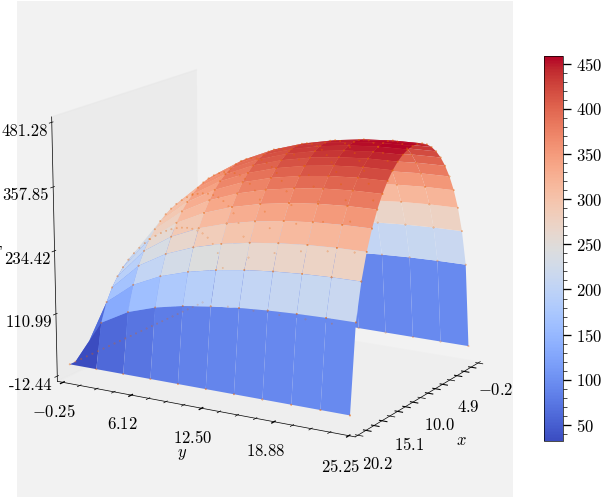

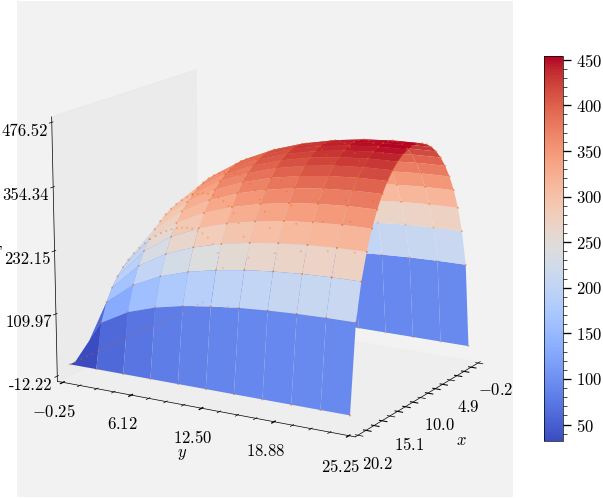

In [3]:
for i in range(2):
    Plot = plot(d.xi[0], d.xi[1], NLS[i])
    Plot.surface_()
plt.show()

## ECSW Hyper-reduction

### Train-Test split

In [4]:
# You may choose to define you train and test set data too!
# train_mask, test_mask = train_test_split(N_snap)

NLS_train = NLS[train_mask][:,d.mask]
param_list_train = param_list[train_mask]

NLS_test = NLS[test_mask][:,d.mask]

### Mean Subtraction

In [5]:
NLS_train_mean = np.mean(NLS_train,axis=0)
NLS_train_mean.shape
NLS_train_ms = NLS_train - NLS_train_mean


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

Number of modes selected: 2


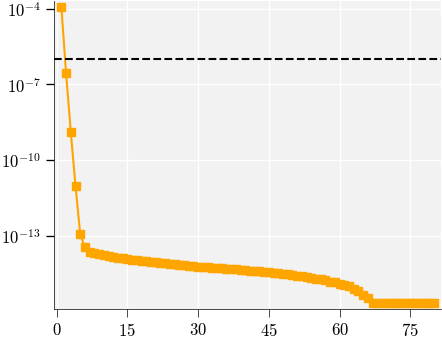

In [6]:
# plt.rcParams['figure.dpi'] = 100
n_sel, U = svd_mode_selector(NLS_train_ms, tolerance=1e-6,modes=True)
V_sel = U[:, :n_sel]

In [7]:
# for i in range(n_sel):
#     plot(d.xi[0], d.xi[1], V_sel[:,i],elev=15, azim=60).surface_()

### Step 2: Perform NNLS for ECSW

In [8]:
tic_h_setup_b = time.time()

N_snap_train,_ = np.shape(NLS_train)
tol = 1e-2 #1e-4

# xi, residual = ecsw_red_ms(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap_train, d.mask, NLS_train_ms, NLS_train_mean, tol=tol)
data = {'K_mus':K_mus,'q_mus':q_mus}
xi, residual = ecsw_red(d, V_sel, d.Le, data, n_sel, N_snap_train, NLS_train_ms, NLS_train_mean, Data_cls.FOS.residual_func, tol=tol)


toc_h_setup_b = time.time()

norm of rhs: 169933.16778901246


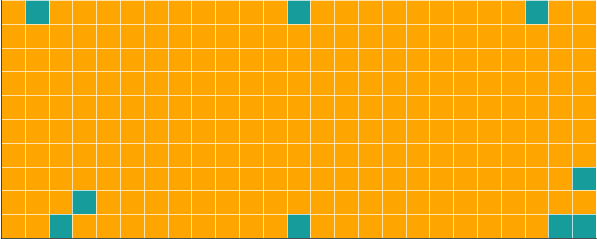

Fraction of total elements active in the ROM: 3.6%
residual: 1.157897099957662e-06


In [9]:
plot(0,0,0).element_((d.ncells[0],d.ncells[1]), xi, d.ncells)
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")
print(f"residual: {residual}")

### Specifiy the subtracted mean

In [10]:
Data_cls.mean = NLS_train_mean


### ROM Simulation

In [11]:
eval_rom = True

if eval_rom:
    ROM_h = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel, xi=xi) #, N_rom_snap=1)
    ROM_h.run_simulation_h_ecsw()

In [12]:
if eval_rom:
    ROM = ROM_simulation(Data_cls, NLS_test, param_list, test_mask, V_sel) #, N_rom_snap=1)
    ROM.run_simulation()

### Performance Statistics

In [13]:
NLS_rom_h = np.asarray(ROM_h.NL_solutions_rom)
ROM_speed_up_h = ROM_h.speed_up_h
ROM_relative_error_h = ROM_h.rom_error

In [14]:
if eval_rom:
    NLS_rom = np.asarray(ROM.NL_solutions_rom)
    ROM_speed_up = ROM.speed_up
    ROM_relative_error = ROM.rom_error

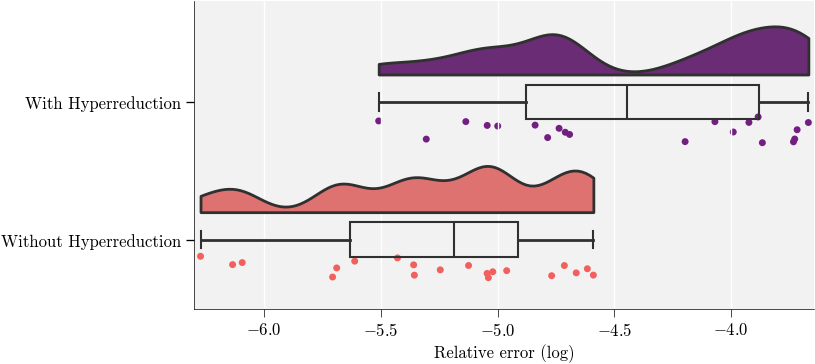

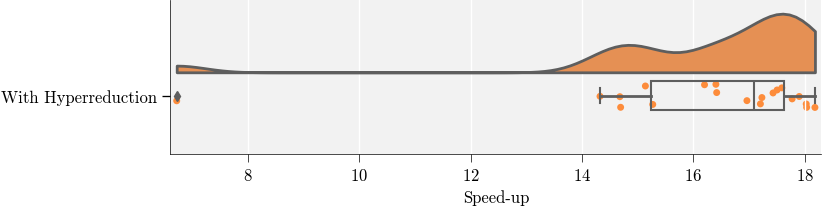

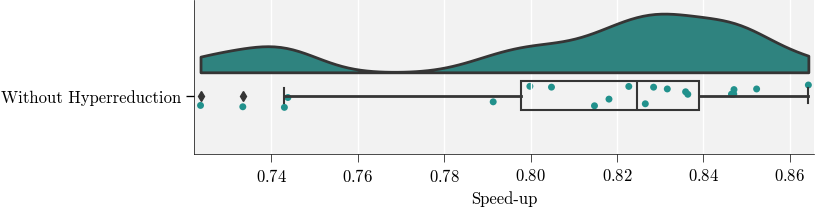

In [15]:
df_A = pd.DataFrame({'':'With Hyperreduction','Relative error (log)':np.log10(ROM_relative_error_h)})
df_B = pd.DataFrame({'':'Without Hyperreduction','Relative error (log)':np.log10(ROM_relative_error)})

# Combine the DataFrames
df = pd.concat([df_A, df_B])

fig, ax = plt.subplots(figsize=(8, 4))
pt.RainCloud(x = '', y = 'Relative error (log)', data = df, palette = "magma", bw = 0.2,
    width_viol = .7, ax = ax, orient = "h",pointplot = False, dodge=False, alpha=1.0, width_box = 0.25, linewidth=2, point_size =5.0, move=0.2)
plt.show()

# ===

df_C = pd.DataFrame({'':'With Hyperreduction','Speed-up':ROM_speed_up_h})
df_D = pd.DataFrame({'':'Without Hyperreduction','Speed-up':ROM_speed_up})


fig, ax = plt.subplots(figsize=(8.4, 2))
pt.RainCloud(x = '', y = 'Speed-up', data = df_C, palette = "Oranges",
    width_viol = 1.0, ax = ax, orient = "h",pointplot = False, dodge=True, alpha=1.0, width_box = 0.25, linewidth=2, point_size =5.0)

fig, ax = plt.subplots(figsize=(8, 2))
pt.RainCloud(x = '', y = 'Speed-up', data = df_D, palette = "viridis",
    width_viol = 1.0, ax = ax, orient = "h",pointplot = False, dodge=True, alpha=1.0, width_box = 0.25, linewidth=2, point_size =5.0)
plt.show()

In [16]:
# data_stats(ROM_speed_up_h, show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Speed-up", ylabel="Frequency");
# data_stats(np.log10(ROM_relative_error_h), show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Relative error (log)", ylabel="Frequency");

In [17]:
# if eval_rom:    
#     data_stats(ROM_speed_up, show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Speed-up", ylabel="Frequency");
#     data_stats(np.log10(ROM_relative_error), show_histogram=True, show_boxplot=True, show_mean_std=True, xlabel="Relative error (log)", ylabel="Frequency");